# Here, we will train a simple model on a simple dataset to understand the effect of the hparams:

In [1]:
output_path = './outputs/graphs/'
results_path = 'outputs/toy_example/'

In [2]:
import numpy as np
import pandas as pd
import tqdm
import torch
import torch.nn as nn
import os
import typing as t
from catalyst.metrics import AccuracyMetric
import sklearn.datasets as skdatasets
import sklearn.model_selection as skmodel_selection
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import graph_code.graphing_utils as plotting

from loss_adapted_plasticity import SourceLossWeighting

In [3]:
colwidth = 4.22716535
pagewidth = colwidth * 2

Training functions:

In [4]:
# training functions
def train_batch(
    model,
    optimiser,
    x,
    y,
    sources,
    label_loss_weighting,
    device,
    writer=None,
):
    model.to(device)
    model.train()

    optimiser.zero_grad()

    label_loss, outputs = model(
        x,
        y,
        return_loss=True,
    )

    if label_loss_weighting is not None:
        label_loss = label_loss_weighting(
            losses=label_loss, sources=sources, writer=writer, writer_prefix="label"
        )

    loss = torch.mean(label_loss)
    loss.backward()
    optimiser.step()

    return loss.item(), outputs


def train_epoch(
    model,
    train_loader,
    optimiser,
    device,
    epoch_number,
    label_loss_weighting,
    scheduler=None,
    writer=None,
    verbose=True,
):
    model.to(device)

    model.train()

    train_loss = 0
    train_total = 0
    acc_meter = AccuracyMetric(topk=[1], compute_on_call=False)

    lr = optimiser.param_groups[0]["lr"]
    pbar = tqdm.tqdm(
        train_loader, 
        desc=f"Train Epoch {epoch_number+1}, LR {lr:.4f}", 
        disable=not verbose
    )

    for batch_idx, (inputs, targets, sources) in enumerate(pbar):
        inputs, targets, sources = (
            inputs.to(device),
            targets.to(device),
            sources.to(device),
        )
        sources = sources.squeeze(-1)

        loss, outputs = train_batch(
            model,
            optimiser,
            inputs,
            targets,
            sources,
            label_loss_weighting=label_loss_weighting,
            device=device,
            writer=writer,
        )

        if writer is not None:
            writer.add_scalar(
                "Train Loss",
                loss,
                epoch_number * len(train_loader) + batch_idx,
            )

        acc_meter.update(outputs, targets)

        train_loss += loss * targets.size(0)
        train_total += targets.size(0)


        pbar.set_postfix(
            {
                "Loss": train_loss / train_total,
            }
        )

    if scheduler is not None:
        scheduler.step()

    metrics = {
        "Loss": train_loss / train_total,
        "Accuracy": acc_meter.compute_key_value()["accuracy01"],
    }

    pbar.set_postfix(metrics)
    pbar.close()

    return train_loss / train_total, metrics


def test(model, test_loader, device, verbose=True):
    model.to(device)
    model.eval()

    acc_meter = AccuracyMetric(topk=[1])

    with torch.no_grad():
        test_loss = 0
        test_total = 0
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            label_loss, outputs = model(
                inputs,
                y=targets,
                return_loss=True,
            )

            loss = torch.mean(label_loss)
            acc_meter.update(outputs, targets)
            test_loss += loss.item() * targets.size(0)
            test_total += targets.size(0)

        metrics = {
            "Loss": test_loss / test_total,
            "Accuracy": acc_meter.compute_key_value()["accuracy01"],
        }
        if verbose:
            print(
                "Test Loss",
                test_loss / test_total,
                "Test Acc",
                metrics["Accuracy"],
            )

    return test_loss / test_total, metrics

Result logging:

In [5]:
class SimpleWriter(object):
    def __init__(self):
        self.values = []
    
    def add_scalar(self, name, value, step):

        if type(value) == torch.Tensor:
            value = value.item()
        
        if type(step) == torch.Tensor:
            step = step.item()
        
        self.values.append(
            {
                "name": name,
                "value": value,
                "step": step,
            }
        )

Function to make data noisy:

In [6]:
def data_corruptor(
    X: np.array, y: np.array, sources: np.array, noisy_sources: t.List[int],
    noise_levels: t.List[float], seed: int
):
    
    X_out = X.copy()
    y_out = y.copy()
    sources_out = sources.copy()

    for s, nl in zip(noisy_sources, noise_levels):
        # random states
        rng = np.random.default_rng(seed)
        seed += 1
        # randomly choose the indices of the source to corrupt
        idx = np.argwhere(sources == s).reshape(-1)
        idx_noise = rng.choice(idx, size=int(len(idx) * nl), replace=False)
        
        # corrupt the labels
        y_out[idx_noise] = 1 - y_out[idx_noise]

    return X_out, y_out, sources_out

Example data:

In [7]:
seed = 42

n_sources = 5

X, y = skdatasets.make_moons(n_samples=10000, noise=0.1, random_state=seed)
seed += 1
sources = np.random.default_rng(seed).integers(0, n_sources, size=len(X))
seed += 1

X = X.astype(np.float32)
y = y.astype(np.int64)

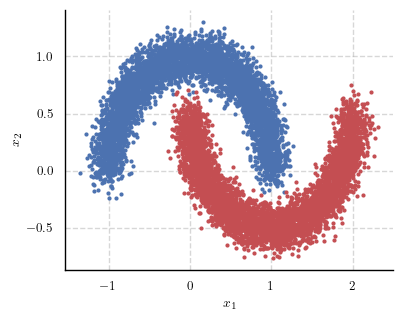

In [8]:
with plotting.paper_theme():
    plt.close()

    fig, ax = plt.subplots(figsize=(colwidth, colwidth*0.8))
    
    ax.plot(X[y == 0, 0], X[y == 0, 1], 'bo', markersize=2)
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'ro', markersize=2)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    
    plt.show()

In [9]:
train_test_split = 0.8

(
    X_train, X_test, y_train, y_test, sources_train, sources_test
) = skmodel_selection.train_test_split(
    X, y, sources, train_size=train_test_split, random_state=seed
)
seed += 1

In [10]:
ns_rng = np.random.default_rng(seed)
nl_rng = np.random.default_rng(seed + 1)

n_noisy_sources = 4

X_train_noise, y_train_noise, sources_train_noise = data_corruptor(
    X_train, y_train, sources_train, 
    noisy_sources=ns_rng.choice(n_sources, size=n_noisy_sources, replace=False),
    noise_levels=np.linspace(0.25, 1.0, n_noisy_sources, endpoint=True),
    seed=seed + 2
)

seed += 3

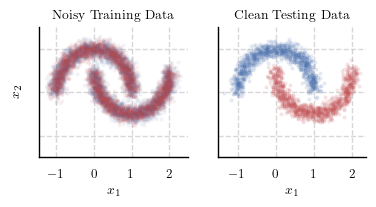

In [11]:
with plotting.paper_theme():
    plt.close()
    fig, axes = plt.subplots(1, 2, figsize=(colwidth, colwidth*0.4))
    
    ax1, ax2 = axes

    ax1.plot(
        X_train_noise[y_train_noise == 0, 0], 
        X_train_noise[y_train_noise == 0, 1], 
        'bo', 
        markersize=2,
        alpha=0.05
    )
    ax1.plot(
        X_train_noise[y_train_noise == 1, 0], 
        X_train_noise[y_train_noise == 1, 1], 
        'ro', 
        markersize=2,
        alpha=0.05
    )

    ax1.set_xlabel("$x_1$")
    ax1.set_ylabel("$x_2$")
    ax1.set_title("Noisy Training Data")
    ax1.set_ylim(-1.5, 1.5)

    ax2.plot(
        X_test[y_test == 0, 0], 
        X_test[y_test == 0, 1], 
        'bo', 
        markersize=2,
        alpha=0.1
    )
    
    ax2.plot(
        X_test[y_test == 1, 0], 
        X_test[y_test == 1, 1], 
        'ro', 
        markersize=2,
        alpha=0.1
    )

    ax2.sharey(ax1)

    ax2.set_xlabel("$x_1$")
    ax2.set_ylabel("")
    ax2.set_yticklabels([])
    ax2.set_title("Clean Testing Data")
    ax1.set_ylim(-1.5, 1.5)
    
    plt.show()

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 100*X_train.shape[1]),
            nn.ReLU(),
            nn.Linear(100*X_train.shape[1], 100*X_train.shape[1]),
            nn.ReLU(),
            nn.Linear(100*X_train.shape[1], 2),
        )
        self.criterion = nn.CrossEntropyLoss(reduction="none")

    def forward(self, x, y=None, return_loss=False):
        out = self.net(x)
        if return_loss:
            loss = self.criterion(out, y)
            return loss, out
        return out

In [13]:
history_length_list = [2, 5, 25, 50, 250, 500, 1000]
depression_strength_list = [0.05, 0.1, 0.25, 0.5, 1.0, 1.5, 2.0,]
leniency_list = [0.05, 0.1, 0.25, 0.5, 1.0, 2.0, 4.0]

In [14]:
experiment_params = []

experiment_params.extend(
    [
        {
        'history_length': h,
        'depression_strength': 1.0,
        'leniency': 1.0
        }
        for h in history_length_list
    ]
)

experiment_params.extend(
    [
        {
        'history_length': 50,
        'depression_strength': d,
        'leniency': 1.0
        }
        for d in depression_strength_list
    ]
)

experiment_params.extend(
    [
        {
        'history_length': 50,
        'depression_strength': 1.0,
        'leniency': l
        }
        for l in leniency_list
    ]
)

# de-duplication
experiment_params = [
    dict(t) for t in {tuple(d.items()) for d in experiment_params}
]

In [15]:
if False:

    n_repeats = 1
    n_epochs = 25
    batch_size = 128
    n_sources = 5
    n_noisy_sources = 4
    noise_levels = [0.025, 0.05, 0.25, 1.0]

    results = []
    writers = []

    pbar = tqdm.tqdm(
        total=len(experiment_params) * n_repeats,
        desc="Experiments",
    )

    for r in range(n_repeats):
        ns_rng = np.random.default_rng(seed)
        nl_rng = np.random.default_rng(seed + 1)

        X_train_noise, y_train_noise, sources_train_noise = data_corruptor(
            X_train, y_train, sources_train, 
            noisy_sources=ns_rng.choice(n_sources, size=n_noisy_sources, replace=False),
            noise_levels=noise_levels,
            seed=seed + 2
        )

        seed += 3

        # wrapper data in dataset
        train_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train_noise), 
            torch.from_numpy(y_train_noise), 
            torch.from_numpy(sources_train_noise)
        )

        test_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_test), 
            torch.from_numpy(y_test), 
        )

        # put dataset in train loader
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
        )

        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False,
        )
        
        for ep in experiment_params:
            history_length = ep["history_length"]
            depression_strength = ep["depression_strength"]
            leniency = ep["leniency"]

            writer_this = SimpleWriter()

            mlp = MLP()

            optimiser = torch.optim.Adam(
                params=mlp.parameters(),
                lr=0.01,
                weight_decay=0.0001
            )

            source_loss_weighting = SourceLossWeighting(
                history_length=history_length,
                warmup_iters=100,
                depression_strength=depression_strength,
                discrete_amount=0.005,
                leniency=leniency,
            )

            results_this = []
            for epoch in range(n_epochs):
                train_epoch(
                    mlp,
                    train_loader,
                    optimiser,
                    device="cpu",
                    epoch_number=epoch,
                    label_loss_weighting=source_loss_weighting,
                    writer=writer_this,
                    verbose=False,
                )

                test_loss, test_metrics = test(
                    mlp, test_loader, device="cpu", verbose=False
                )

                results_this.append(
                    {
                        "history_length": history_length,
                        "depression_strength": depression_strength,
                        "leniency": leniency,
                        "repeat": r,
                        "epoch": epoch,
                        "test_loss": test_loss,
                        "test_acc": test_metrics["Accuracy"],
                    }
                )
            
            results_this_df = pd.DataFrame(results_this)
            results.append(results_this_df)

            writer_this_df = pd.DataFrame(writer_this.values)
            writers.append(writer_this_df)

            results_this_df.to_parquet(
                results_path + 
                f"results_{history_length}_{depression_strength}_{leniency}_{r}.parquet"
            )
            writer_this_df.to_parquet(
                results_path + 
                f"writer_{history_length}_{depression_strength}_{leniency}_{r}.parquet"
            )

            pbar.update(1)

    pbar.close()

In [16]:
writer_files = [
    f for f in 
    os.listdir(
        results_path
    )
    if "writer" in f
]

In [17]:
writers = []

for fn in tqdm.tqdm(writer_files, desc="Loading writers"):
    writer_this_df = pd.read_parquet(
        results_path + fn
    )

    history_length, depression_strength, leniency, r = [
        float(x) for x in 
        fn.split(".parquet")[0].split("_")[1:]
    ]

    writer_this_df = (
        writer_this_df
        .assign(
            history_length = history_length,
            depression_strength = depression_strength,
            leniency = leniency,
            r = r
        )
        .astype(
            {"history_length": int}
        )
        .set_index(
            [
                "history_length", "depression_strength", "leniency", "r"
            ]
        )
    )
    
    writers.append(writer_this_df)

writers_df = pd.concat(writers).sort_index()

Loading writers: 100%|██████████| 19/19 [00:00<00:00, 30.00it/s]


In [18]:
writer_unreliability_leniency = (
    writers_df
    .loc[(50.0, 1.0)]
    .loc[lambda df: df["name"].str.contains("unreliability")]
)

writer_unreliability_depression_strength = (
    writers_df
    .swaplevel(1, 2)
    .sort_index()
    .loc[(50.0, 1.0)]
    .loc[lambda df: df["name"].str.contains("unreliability")]
)

writer_unreliability_history_length = (
    writers_df
    .swaplevel(0, 2)
    .sort_index()
    .loc[(1.0, 1.0)]
    .loc[lambda df: df["name"].str.contains("unreliability")]
)

In [19]:
writer_depression_multiplier_leniency = (
    writers_df
    .loc[(50.0, 1.0)]
    .loc[lambda df: df["name"].str.contains("depression_multiplier")]
)

writer_depression_multiplier_depression_strength = (
    writers_df
    .swaplevel(1, 2)
    .sort_index()
    .loc[(50.0, 1.0)]
    .loc[lambda df: df["name"].str.contains("depression_multiplier")]
)

writer_depression_multiplier_history_length = (
    writers_df
    .swaplevel(0, 2)
    .sort_index()
    .loc[(1.0, 1.0)]
    .loc[lambda df: df["name"].str.contains("depression_multiplier")]
)

In [20]:
noise_levels = [0.025, 0.05, 0.25, 1.0]

ns_rng = np.random.default_rng(seed)
noisy_sources = ns_rng.choice(n_sources, size=n_noisy_sources, replace=False)

noise_levels = {f"source_{s}": n for s, n in zip(noisy_sources, noise_levels)}

hue_order = {}

for name in (
    writer_depression_multiplier_depression_strength.name.unique()
):
    for short_name in noise_levels:
        if short_name in name:
            hue_order[name] = noise_levels[short_name]

    if name not in hue_order:
        hue_order[name] = 0.0


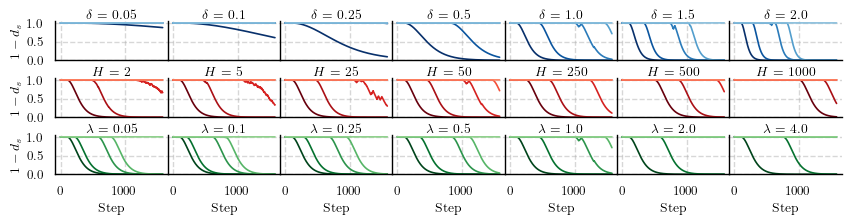

In [21]:
unique_leniency = (
    writers_df.index.get_level_values("leniency").unique().sort_values()
)
unique_depression_strength = (
    writers_df.index.get_level_values("depression_strength").unique().sort_values()
)
unique_history_length = (
    writers_df.index.get_level_values("history_length").unique().sort_values()
)

with plotting.paper_theme():
    plt.close()
    fig = plt.figure(figsize=(pagewidth, pagewidth*0.25))
    gs = fig.add_gridspec(3, len(unique_leniency))


    # as depression strength increases
    for nax, depression_strength in enumerate(unique_depression_strength):
        ax = fig.add_subplot(gs[0, nax])
        sns.lineplot(
            data=(
                writer_depression_multiplier_depression_strength
                .loc[depression_strength]
                .reset_index()
            ),
            x="step",
            y="value",
            hue="name",
            hue_order=sorted(hue_order, key=hue_order.get, reverse=True),
            ax=ax,
            legend=False,
            palette=matplotlib.colormaps["Blues_r"](np.linspace(0, 1, 8))[:len(noise_levels)+1].tolist(),
            alpha=1,
        )
        ax.set_xlabel("Step")
        ax.set_ylabel("$1-d_s$")
        ax.set_title(f"$\delta$ = {depression_strength}", y=0.85)
        ax.set_ylim(0, 1.05)
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_xlabel("")
        ax.set_xticks([0, 1000])
        ax.set_xticklabels([])
        if nax > 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])

    # as history length increases
    for nax, history_length in enumerate(unique_history_length):
        ax = fig.add_subplot(gs[1, nax])
        sns.lineplot(
            data=(
                writer_depression_multiplier_history_length
                .loc[history_length]
                .reset_index()
            ),
            x="step",
            y="value",
            hue="name",
            hue_order=sorted(hue_order, key=hue_order.get, reverse=True),
            ax=ax,
            legend=False,
            palette=matplotlib.colormaps["Reds_r"](np.linspace(0, 1, 8))[:len(noise_levels)+1].tolist(),
            alpha=1,
        )
        ax.set_xlabel("Step")
        ax.set_ylabel("$1-d_s$")
        ax.set_title(f"$H$ = {history_length}", y=0.85)
        ax.set_ylim(0, 1.05)
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_xlabel("")
        ax.set_xticks([0, 1000])
        ax.set_xticklabels([])
        if nax > 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])


    # as leniency increases
    for nax, leniency in enumerate(unique_leniency):
        ax = fig.add_subplot(gs[2, nax])
        sns.lineplot(
            data=(
                writer_depression_multiplier_leniency
                .loc[leniency]
                .reset_index()
            ),
            x="step",
            y="value",
            hue="name",
            hue_order=sorted(hue_order, key=hue_order.get, reverse=True),
            ax=ax,
            legend=False,
            palette=matplotlib.colormaps["Greens_r"](np.linspace(0, 1, 8))[:len(noise_levels)+1].tolist(),
            alpha=1,
        )
        ax.set_xlabel("Step")
        ax.set_ylabel("$1-d_s$")
        ax.set_title(f"$\lambda$ = {leniency}", y=0.85)
        ax.set_ylim(0, 1.05)
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_xticks([0, 1000])
        if nax > 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])

    fig.subplots_adjust(
        wspace=0.0, hspace=0.45, 
        left=0.06, right=0.99, 
        bottom=0.2, top=0.925
    )

    plotting.save_fig(fig, output_path + "toy_example")

    plt.show()

In [22]:
history_length_list = [5, 10, 25, 50, 100, 200, 400, 800]
depression_strength_list = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
leniency_list = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]

In [23]:
experiment_params = []

experiment_params.extend(
    [
        {
        'history_length': h,
        'depression_strength': 1.0,
        'leniency': 1.0
        }
        for h in history_length_list
    ]
)

experiment_params.extend(
    [
        {
        'history_length': 50,
        'depression_strength': d,
        'leniency': 1.0
        }
        for d in depression_strength_list
    ]
)

experiment_params.extend(
    [
        {
        'history_length': 50,
        'depression_strength': 1.0,
        'leniency': l
        }
        for l in leniency_list
    ]
)

# de-duplication
experiment_params = [
    dict(t) for t in {tuple(d.items()) for d in experiment_params}
]

In [24]:
if False:

    n_repeats = 10
    n_epochs = 25
    batch_size = 128
    n_sources = 5
    n_noisy_sources = 4
    noise_levels = [0.025, 0.05, 0.25, 1.0]

    results = []

    pbar = tqdm.tqdm(
        total=len(experiment_params) * n_repeats,
        desc="Experiments",
    )

    for r in range(n_repeats):
        ns_rng = np.random.default_rng(seed)
        nl_rng = np.random.default_rng(seed + 1)

        X_train_noise, y_train_noise, sources_train_noise = data_corruptor(
            X_train, y_train, sources_train, 
            noisy_sources=ns_rng.choice(n_sources, size=n_noisy_sources, replace=False),
            noise_levels=noise_levels,
            seed=seed + 2
        )

        seed += 3

        # wrapper data in dataset
        train_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train_noise), 
            torch.from_numpy(y_train_noise), 
            torch.from_numpy(sources_train_noise)
        )

        test_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_test), 
            torch.from_numpy(y_test), 
        )

        # put dataset in train loader
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
        )

        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False,
        )
        
        for ep in experiment_params:
            history_length = ep["history_length"]
            depression_strength = ep["depression_strength"]
            leniency = ep["leniency"]

            mlp = MLP()

            optimiser = torch.optim.Adam(
                params=mlp.parameters(),
                lr=0.01,
                weight_decay=0.0001
            )

            source_loss_weighting = SourceLossWeighting(
                history_length=history_length,
                warmup_iters=100,
                depression_strength=depression_strength,
                discrete_amount=0.005,
                leniency=leniency,
            )

            results_this = []
            for epoch in range(n_epochs):
                train_epoch(
                    mlp,
                    train_loader,
                    optimiser,
                    device="cpu",
                    epoch_number=epoch,
                    label_loss_weighting=source_loss_weighting,
                    writer=None,
                    verbose=False,
                )

                test_loss, test_metrics = test(
                    mlp, test_loader, device="cpu", verbose=False
                )

                results_this.append(
                    {
                        "history_length": history_length,
                        "depression_strength": depression_strength,
                        "leniency": leniency,
                        "repeat": r,
                        "epoch": epoch,
                        "test_loss": test_loss,
                        "test_acc": test_metrics["Accuracy"],
                    }
                )
            
            results_this_df = pd.DataFrame(results_this)
            results.append(results_this_df)

            results_this_df.to_parquet(
                results_path + 
                "hparam_sweep/" + 
                f"results_{history_length}_{depression_strength}_{leniency}_{r}.parquet"
            )

            pbar.update(1)

    pbar.close()

In [25]:
result_files = [
    f for f in 
    os.listdir(
        results_path + "hparam_sweep/"
    )
    if "results" in f
]

In [26]:
results = []

for fn in tqdm.tqdm(result_files, desc="Loading results"):
    result_this_df = pd.read_parquet(
        results_path + "hparam_sweep/" + fn
    )

    history_length, depression_strength, leniency, r = [
        float(x) for x in 
        fn.split(".parquet")[0].split("_")[1:]
    ]

    result_this_df = (
        result_this_df
        .assign(
            history_length = history_length,
            depression_strength = depression_strength,
            leniency = leniency,
            r = r
        )
        .astype(
            {"history_length": int}
        )
        .set_index(
            [
                "history_length", "depression_strength", "leniency", "r"
            ]
        )
    )
    
    results.append(result_this_df)

results_df = pd.concat(results).sort_index()

Loading results: 100%|██████████| 200/200 [00:01<00:00, 124.56it/s]


In [27]:
results_df

repeat  epoch  test_loss  \
history_length depression_strength leniency r                               
5              1.0                 1.0      0.0       0      0   0.308558   
                                            0.0       0      1   0.364288   
                                            0.0       0      2   0.372620   
                                            0.0       0      3   0.275359   
                                            0.0       0      4   0.202058   
...                                                 ...    ...        ...   
800            1.0                 1.0      9.0       9     20   0.085119   
                                            9.0       9     21   0.066463   
                                            9.0       9     22   0.046603   
                                            9.0       9     23   0.037956   
                                            9.0       9     24   0.039286   

                                                 test_acc  
history_length depression_strength leniency r              
5              1.0                 1.0      0.0    0.9700  
                                            0.0    0.9650  
                                            0.0    0.9995  
                                            0.0    0.9940  
                                            0.0    0.9980  
...                                                   ...  
800            1.0                 1.0      9.0    0.9995  
                                            9.0    0.9995  
                                            9.0    0.9990  
                                            9.0    0.9990  
                                            9.0    0.9975  

[5000 rows x 4 columns]

In [28]:
result_depression_multiplier_leniency = (
    results_df
    .loc[(50.0, 1.0)]
)

result_depression_multiplier_depression_strength = (
    results_df
    .swaplevel(1, 2)
    .sort_index()
    .loc[(50.0, 1.0)]
)

result_depression_multiplier_history_length = (
    results_df
    .swaplevel(0, 2)
    .sort_index()
    .loc[(1.0, 1.0)]
)

In [29]:
print(
    (
        result_depression_multiplier_leniency
        .groupby(["leniency", 'repeat', ])
        .max()
        .reset_index()
        .rename(columns={"test_loss": "Test Loss"})
        .groupby("leniency")
        [['Test Loss']]
        .agg(['mean', 'std'])
        .assign(
            mean_std = lambda x: 
                np.round(x['Test Loss', 'mean'], 2).astype(str) 
                + " ± "
                + np.round(x['Test Loss', 'std'], 2).astype(str),
        )
        ['mean_std']
        .to_frame("Test Loss")
        .T
        .to_markdown()
    )
)

|           | 0.125       | 0.25        | 0.5         | 1.0         | 2.0         | 4.0         | 8.0         |
|:----------|:------------|:------------|:------------|:------------|:------------|:------------|:------------|
| Test Loss | 0.36 ± 0.03 | 0.35 ± 0.03 | 0.39 ± 0.04 | 0.35 ± 0.05 | 0.38 ± 0.04 | 0.38 ± 0.04 | 0.39 ± 0.03 |


In [30]:
print(
    (
        result_depression_multiplier_depression_strength
        .groupby(["depression_strength", 'repeat', ])
        .max()
        .reset_index()
        .rename(columns={"test_loss": "Test Loss"})
        .groupby("depression_strength")
        [['Test Loss']]
        .agg(['mean', 'std'])
        .assign(
            mean_std = lambda x: 
                np.round(x['Test Loss', 'mean'], 2).astype(str) 
                + " ± "
                + np.round(x['Test Loss', 'std'], 2).astype(str),
        )
        ['mean_std']
        .to_frame("Test Loss")
        .T
        .to_markdown()
    )
)

|           | 0.125       | 0.25        | 0.5         | 1.0         | 2.0         | 4.0         | 8.0         |
|:----------|:------------|:------------|:------------|:------------|:------------|:------------|:------------|
| Test Loss | 0.38 ± 0.02 | 0.39 ± 0.03 | 0.39 ± 0.04 | 0.35 ± 0.05 | 0.35 ± 0.03 | 0.64 ± 0.06 | 0.72 ± 0.06 |


In [31]:
print(
    (
        result_depression_multiplier_history_length
        .groupby(["history_length", 'repeat', ])
        .max()
        .reset_index()
        .rename(columns={"test_loss": "Test Loss"})
        .groupby("history_length")
        [['Test Loss']]
        .agg(['mean', 'std'])
        .assign(
            mean_std = lambda x: 
                np.round(x['Test Loss', 'mean'], 2).astype(str) 
                + " ± "
                + np.round(x['Test Loss', 'std'], 2).astype(str),
        )
        ['mean_std']
        .to_frame("Test Loss")
        .T
        .to_markdown()
    )
)

|           | 5           | 10          | 25          | 50          | 100         | 200         | 400        | 800        |
|:----------|:------------|:------------|:------------|:------------|:------------|:------------|:-----------|:-----------|
| Test Loss | 0.37 ± 0.02 | 0.38 ± 0.04 | 0.38 ± 0.03 | 0.35 ± 0.05 | 0.37 ± 0.05 | 0.39 ± 0.04 | 0.4 ± 0.03 | 0.4 ± 0.03 |


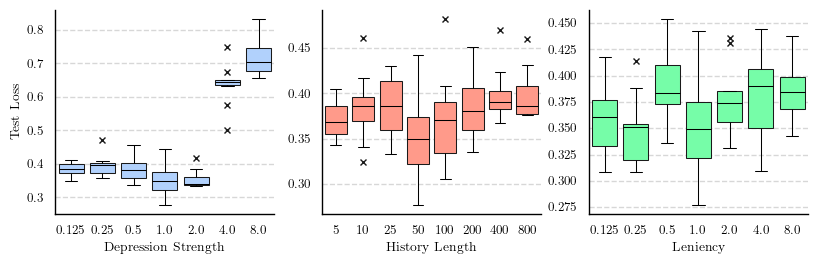

In [32]:
with plotting.paper_theme():
    plt.close()

    linewidth = 0.75

    fig = plt.figure(figsize=(pagewidth, pagewidth/3))
    gs = fig.add_gridspec(1, 3)

    colour_dict = {
        "depression_strength": "xkcd:powder blue",
        "history_length": "xkcd:peachy pink",
        "leniency": "xkcd:light bluish green",
    }

    results_plot_dict = {
        "depression_strength": result_depression_multiplier_depression_strength,
        "history_length": result_depression_multiplier_history_length,
        "leniency": result_depression_multiplier_leniency,
    }

    nice_names = {
        "depression_strength": "Depression Strength",
        "history_length": "History Length",
        "leniency": "Leniency",
    }

    for nax, (key, results_plot) in enumerate(results_plot_dict.items()):

        ax = fig.add_subplot(gs[0, nax])

        ax = sns.boxplot(
            data=(
                results_plot
                .groupby([key, 'repeat'])
                .max()
                .reset_index()
                .rename(columns={"test_loss": "Test Loss"})
            ),
            x=key,
            y="Test Loss",
            patch_artist=True,
            boxprops=dict(facecolor=colour_dict[key], linewidth=linewidth),
            whiskerprops=dict(color='black', linewidth=linewidth),
            medianprops=dict(color='black', linewidth=linewidth),
            capprops=dict(color='black', linewidth=linewidth),
            flierprops=dict(marker='x', markersize=4),
            ax=ax
        )

        ax.set_xlabel(nice_names[key])
        if nax == 0:
            ax.set_ylabel("Test Loss")
        else:
            ax.set_ylabel("")

    fig.subplots_adjust(
        wspace=0.22, hspace=0.0, 
        left=0.1, right=0.99, 
        bottom=0.2, top=0.925
    )

    plt.show()


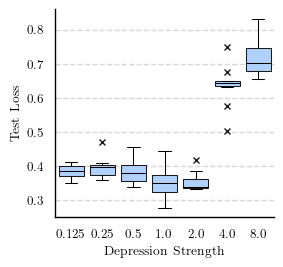

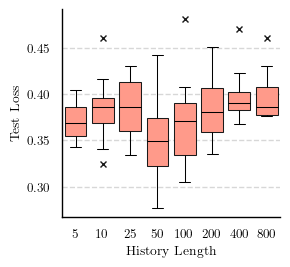

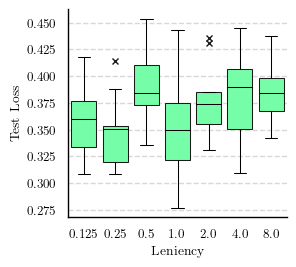

In [33]:
with plotting.paper_theme():
    plt.close()

    linewidth = 0.75

    colour_dict = {
        "depression_strength": "xkcd:powder blue",
        "history_length": "xkcd:peachy pink",
        "leniency": "xkcd:light bluish green",
    }

    results_plot_dict = {
        "depression_strength": result_depression_multiplier_depression_strength,
        "history_length": result_depression_multiplier_history_length,
        "leniency": result_depression_multiplier_leniency,
    }

    nice_names = {
        "depression_strength": "Depression Strength",
        "history_length": "History Length",
        "leniency": "Leniency",
    }

    for nax, (key, results_plot) in enumerate(results_plot_dict.items()):

        fig, ax = plt.subplots(figsize=((2/3)*colwidth, 0.6*colwidth))

        ax = sns.boxplot(
            data=(
                results_plot
                .groupby([key, 'repeat'])
                .max()
                .reset_index()
                .rename(columns={"test_loss": "Test Loss"})
            ),
            x=key,
            y="Test Loss",
            patch_artist=True,
            boxprops=dict(facecolor=colour_dict[key], linewidth=linewidth),
            whiskerprops=dict(color='black', linewidth=linewidth),
            medianprops=dict(color='black', linewidth=linewidth),
            capprops=dict(color='black', linewidth=linewidth),
            flierprops=dict(marker='x', markersize=4, linewidth=0.25),
            ax=ax
        )

        ax.set_xlabel(nice_names[key])
        ax.set_ylabel("Test Loss")

        fig.subplots_adjust(
            left=0.215, right=0.99, 
            bottom=0.16, top=0.98
        )

        fig.savefig(output_path + f"toy_example_hparam_{key}_boxplot.pdf")
        fig.savefig(output_path + f"toy_example_hparam_{key}_boxplot.png")

    plt.show()
